# Functions and imports

Imports and the functions that call the HI-VAE, modified from the paper version only to allow inputting s_codes and z_codes manually.

In [31]:
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import os
import re
import pandas as pd
import numpy as np
from IPython.display import Audio
import seaborn as sns

import helpers # this is where the main training/decoding functions are, modified from teh original HIVAE main.py

#import warnings 
#warnings.filterwarnings('ignore') ########## NOTE: comment out for testing in case it's hiding problems

def set_settings(opts,nepochs=500,modload=False,save=True): # note: modload doesnt do anything right now, hardcoded in helpers.py
    'replace setting template placeholders with file info'
    inputf=re.sub('.csv','',opts['files'].iloc[0])
    #missf=inputf+'_missing.csv'
    typef=inputf+'_types.csv'
    
    template = '--epochs NEPOCHS --model_name model_HIVAE_inputDropout --restore MODLOAD \
        --data_file data_python_NotMissing/INPUT_FILE.csv --types_file data_python_NotMissing/TYPES_FILE \
         --batch_size NBATCH --save NEPFILL --save_file SAVE_FILE\
        --dim_latent_s SDIM --dim_latent_z 1 --dim_latent_y YDIM \
        --learning_rate LRATE'
    
    # replace placeholders in template
    settings = re.sub('INPUT_FILE',inputf,template)
    settings = re.sub('NBATCH',str(opts['nbatch'].iloc[0]),settings)
    settings = re.sub('NEPOCHS',str(nepochs),settings)
    settings = re.sub('NEPFILL',str(nepochs-1),settings) if save else re.sub('NEPFILL',str(nepochs*2),settings)
    settings = re.sub('YDIM',str(opts['ydims'].iloc[0]),settings)
    settings = re.sub('SDIM',str(opts['sdims'].iloc[0]),settings)
    #settings = re.sub('MISS_FILE',missf,settings) #if not 'medhist' in inputf else re.sub('--true_miss_file data_python/MISS_FILE','',settings)
    settings = re.sub('TYPES_FILE',typef,settings)
    settings = re.sub('SAVE_FILE',inputf,settings)
    settings = re.sub('LRATE',str(opts['lrates'].iloc[0]),settings)
    settings = re.sub('MODLOAD','1',settings) if modload else re.sub('MODLOAD','0',settings)
    
    return settings

In [32]:
os.getcwd()

'/Users/meemansasood/Documents/Documents_IT/paper/Altoida_VAMBN_paper/data/HI-VAE'

In [33]:
sample_size=178
# get file list
files=[i for i in os.listdir('data_python_Notmissing/') if not '_type' in i and not '_missing' in i and not '.DS_Store' in i and not 'stalone' in i]
files.sort()
print(files)

['ARGlobalTelemetryVariance.csv', 'ARIntroReadTimes.csv', 'ARObjectPlacement.csv', 'ARObjectPlacementFFT.csv']


In [34]:
best_hyper=pd.read_csv('results_Altoida_nmDec2021.csv',  sep = ',')
best_hyper = best_hyper.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
best_hyper.files = best_hyper.files.str.replace('\\_grid.*?\\_results.*?\\_NotMissing', '')
best_hyper

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,loss,lrates,nbatch,wdecay,ydims,files
0,-14.969054,0.010,16.0,0.01,1.0,ARGlobalTelemetryVariance.csv
1,30.252346,0.001,16.0,0.01,1.0,ARObjectPlacement.csv
2,17.598981,0.010,16.0,0.00,1.0,ARIntroReadTimes.csv
3,102.627308,0.001,16.0,0.01,1.0,ARObjectPlacementFFT.csv


In [35]:
sample_size=178
# get file list
files=[i for i in os.listdir('data_python_NotMissing/') if not '_types' in i and not '_missing' in i and i and not '.DS_Store' in i and not 'stalone' in i]
files.sort()
best_hyper = best_hyper.sort_values('files')
best_hyper = best_hyper.reset_index(drop=True)
sds=[1,2,1,1]
sdims=dict(zip(files,sds))
if any(files!=best_hyper['files']):
    print('ERROR')
else:
    best_hyper['sdims']=sds



In [36]:
best_hyper['nbatch'] = best_hyper['nbatch'].astype(int) 
best_hyper['ydims'] = best_hyper['ydims'].astype(int) 
best_hyper['sdims'] = best_hyper['sdims'].astype(int) 

In [37]:
best_hyper = best_hyper[['lrates', 'nbatch', 'wdecay', 'ydims', 'files', 'loss', 'sdims']]
best_hyper

,lrates,nbatch,wdecay,ydims,files,loss,sdims
0,0.010,16,0.01,1,ARGlobalTelemetryVariance.csv,-14.969054,1
1,0.010,16,0.00,1,ARIntroReadTimes.csv,17.598981,2
2,0.001,16,0.01,1,ARObjectPlacement.csv,30.252346,1
3,0.001,16,0.01,1,ARObjectPlacementFFT.csv,102.627308,1


In [38]:
best_hyper.to_csv('best_hyper_ALTOIDA_processed_nmDec2021.csv',index= False)

In [39]:
os.getcwd()

'/Users/meemansasood/Documents/Documents_IT/paper/Altoida_VAMBN_paper/data/HI-VAE'

# General settings

sds is info about which files have what dimension of the "s_codes", that determine the number of mixture components in the "zcodes", our continuous embeddings used in the Bayes Net

# Training

Namespace(batch_size=16, data_file='data_python_NotMissing/ARGlobalTelemetryVariance.csv', dim_latent_s=1, dim_latent_y=1, dim_latent_y_partition=None, dim_latent_z=1, display=1, epochs=500, learning_rate=0.01, miss_file='Missing_test.csv', miss_percentage_test=0.0, miss_percentage_train=0.0, model_name='model_HIVAE_inputDropout', perp=10, plot=1, restore=0, save=499, save_file='ARGlobalTelemetryVariance', true_miss_file=None, types_file='data_python_NotMissing/ARGlobalTelemetryVariance_types.csv')
[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
Initizalizing Variables ...
1.0
Epoch: 0 Rec. Loss: 9.809842456470836 KL s: 0.0 KL z: 0.006937344643202695
Saving Variables ... ./Saved_Networks/ARGlobalTelemetryVariance/ARGlobalTelemetryVariance.ckpt
0.99778
Epoch: 1 Rec. Loss: 9.978134762157094 KL s: 0.0 KL z: 0.0014893212779001756
0.99556
Epoch: 2 Rec. Loss: 10.307841647755016 KL s: 0.0 KL 

Epoch: 90 Rec. Loss: 14.66424187746915 KL s: 0.0 KL z: 1.5077198201959783
0.79798
Epoch: 91 Rec. Loss: 14.730015321211381 KL s: 0.0 KL z: 1.4841189167716287
0.79576
Epoch: 92 Rec. Loss: 14.926858988675205 KL s: 0.0 KL z: 1.4831605607813054
0.79354
Epoch: 93 Rec. Loss: 14.849948276172984 KL s: 0.0 KL z: 1.5680918476798318
0.79132
Epoch: 94 Rec. Loss: 14.804143645546652 KL s: 0.0 KL z: 1.51505755294453
0.7891
Epoch: 95 Rec. Loss: 14.403478188948197 KL s: 0.0 KL z: 1.5144140828739514
0.78688
Epoch: 96 Rec. Loss: 14.926095529036088 KL s: 0.0 KL z: 1.5506766926158557
0.7846599999999999
Epoch: 97 Rec. Loss: 14.8693884936246 KL s: 0.0 KL z: 1.5067723230882124
0.78244
Epoch: 98 Rec. Loss: 14.44230929287997 KL s: 0.0 KL z: 1.518941879272461
0.7802199999999999
Epoch: 99 Rec. Loss: 14.735586859963156 KL s: 0.0 KL z: 1.5418409325859763
0.778
Epoch: 100 Rec. Loss: 14.56275697187944 KL s: 0.0 KL z: 1.5179177089170977
0.7757799999999999
Epoch: 101 Rec. Loss: 14.484940008683639 KL s: 0.0 KL z: 1.57432

Epoch: 183 Rec. Loss: 15.11042560230602 KL s: 0.0 KL z: 1.6351859786293723
0.59152
Epoch: 184 Rec. Loss: 14.743475914001465 KL s: 0.0 KL z: 1.5472227009859951
0.5892999999999999
Epoch: 185 Rec. Loss: 14.973030177029697 KL s: 0.0 KL z: 1.5804034254767678
0.58708
Epoch: 186 Rec. Loss: 14.658322681080211 KL s: 0.0 KL z: 1.535678668455644
0.5848599999999999
Epoch: 187 Rec. Loss: 14.595644170587713 KL s: 0.0 KL z: 1.539669394493103
0.58264
Epoch: 188 Rec. Loss: 14.8702974319458 KL s: 0.0 KL z: 1.5567397421056575
0.5804199999999999
Epoch: 189 Rec. Loss: 14.822488611394709 KL s: 0.0 KL z: 1.5303913246501575
0.5782
Epoch: 190 Rec. Loss: 14.683457894758744 KL s: 0.0 KL z: 1.5643333305012097
0.5759799999999999
Epoch: 191 Rec. Loss: 14.73339861089533 KL s: 0.0 KL z: 1.5137165026231245
0.5737599999999999
Epoch: 192 Rec. Loss: 14.765922979875045 KL s: 0.0 KL z: 1.5132100798866965
0.5715399999999999
Epoch: 193 Rec. Loss: 14.997299801219594 KL s: 0.0 KL z: 1.5257683233781294
0.5693199999999999
Epoch:

Epoch: 270 Rec. Loss: 14.976708672263406 KL s: 0.0 KL z: 1.5517875064503064
0.39837999999999996
Epoch: 271 Rec. Loss: 14.82822357524525 KL s: 0.0 KL z: 1.50143855268305
0.39615999999999996
Epoch: 272 Rec. Loss: 14.88181278922341 KL s: 0.0 KL z: 1.5139332792975686
0.39393999999999996
Epoch: 273 Rec. Loss: 14.738600730895996 KL s: 0.0 KL z: 1.5746926394375889
0.39171999999999996
Epoch: 274 Rec. Loss: 14.91254338351163 KL s: 0.0 KL z: 1.5596775791861794
0.38949999999999996
Epoch: 275 Rec. Loss: 14.276294708251953 KL s: 0.0 KL z: 1.5533236481926658
0.38727999999999996
Epoch: 276 Rec. Loss: 14.815594586459072 KL s: 0.0 KL z: 1.5711126002398403
0.38505999999999996
Epoch: 277 Rec. Loss: 14.77853723005815 KL s: 0.0 KL z: 1.5478335402228616
0.38283999999999996
Epoch: 278 Rec. Loss: 15.004597056995738 KL s: 0.0 KL z: 1.5356602993878452
0.38061999999999996
Epoch: 279 Rec. Loss: 14.824351570822976 KL s: 0.0 KL z: 1.5060304728421299
0.37839999999999996
Epoch: 280 Rec. Loss: 14.733201026916504 KL s:

Epoch: 357 Rec. Loss: 14.94063663482666 KL s: 0.0 KL z: 1.4995852383700283
0.20523999999999998
Epoch: 358 Rec. Loss: 14.868098692460494 KL s: 0.0 KL z: 1.4688727205449885
0.20301999999999998
Epoch: 359 Rec. Loss: 14.748815709894354 KL s: 0.0 KL z: 1.5301598852330989
0.20079999999999998
Epoch: 360 Rec. Loss: 15.14390668002042 KL s: 0.0 KL z: 1.5504329854791814
0.19857999999999998
Epoch: 361 Rec. Loss: 15.057572451504795 KL s: 0.0 KL z: 1.5851578278975054
0.19635999999999998
Epoch: 362 Rec. Loss: 14.890861511230469 KL s: 0.0 KL z: 1.574256723577326
0.19413999999999998
Epoch: 363 Rec. Loss: 14.81581974029541 KL s: 0.0 KL z: 1.5773787173357876
0.19191999999999998
Epoch: 364 Rec. Loss: 14.609830856323242 KL s: 0.0 KL z: 1.4708333015441895
0.18969999999999998
Epoch: 365 Rec. Loss: 14.770299131220037 KL s: 0.0 KL z: 1.5357212803580544
0.18747999999999998
Epoch: 366 Rec. Loss: 14.70089002089067 KL s: 0.0 KL z: 1.53371262550354
0.18525999999999998
Epoch: 367 Rec. Loss: 14.483598102222789 KL s: 

Epoch: 444 Rec. Loss: 14.511401176452637 KL s: 0.0 KL z: 1.4612389152700251
0.012099999999999889
Epoch: 445 Rec. Loss: 14.98459599234841 KL s: 0.0 KL z: 1.5291891639882869
0.009879999999999889
Epoch: 446 Rec. Loss: 14.767914251847701 KL s: 0.0 KL z: 1.5005680539391257
0.007659999999999889
Epoch: 447 Rec. Loss: 14.882759354331277 KL s: 0.0 KL z: 1.5143459276719526
0.005439999999999889
Epoch: 448 Rec. Loss: 14.646540728482334 KL s: 0.0 KL z: 1.5543553720821033
0.0032199999999998896
Epoch: 449 Rec. Loss: 14.872592492537065 KL s: 0.0 KL z: 1.5099695053967563
0.001
Epoch: 450 Rec. Loss: 15.316631403836338 KL s: 0.0 KL z: 1.5460428974845193
0.001
Epoch: 451 Rec. Loss: 14.60201376134699 KL s: 0.0 KL z: 1.5186551809310913
0.001
Epoch: 452 Rec. Loss: 14.63394884629683 KL s: 0.0 KL z: 1.481972336769104
0.001
Epoch: 453 Rec. Loss: 14.83790128881281 KL s: 0.0 KL z: 1.5498848069797864
0.001
Epoch: 454 Rec. Loss: 14.654882431030273 KL s: 0.0 KL z: 1.5143731832504272
0.001
Epoch: 455 Rec. Loss: 14.76

Epoch: 31 Rec. Loss: -18.234389911998402 KL s: 0.563402381810275 KL z: 0.5315388712016019
0.92896
Epoch: 32 Rec. Loss: -18.103822881525215 KL s: 0.5838631608269431 KL z: 0.5293802212585103
0.92674
Epoch: 33 Rec. Loss: -18.130789409984242 KL s: 0.5755291364409707 KL z: 0.5867553732611916
0.92452
Epoch: 34 Rec. Loss: -18.082335992292926 KL s: 0.5549650869586251 KL z: 0.5955385403199629
0.9223
Epoch: 35 Rec. Loss: -18.084227908741344 KL s: 0.5759236162359064 KL z: 0.6070434342731129
0.92008
Epoch: 36 Rec. Loss: -17.866824236783113 KL s: 0.5784482928839597 KL z: 0.5939997299150988
0.91786
Epoch: 37 Rec. Loss: -17.94884829087691 KL s: 0.5691426477648995 KL z: 0.5974315784194253
0.91564
Epoch: 38 Rec. Loss: -18.110069968483664 KL s: 0.5756968639113687 KL z: 0.6049554104154761
0.91342
Epoch: 39 Rec. Loss: -18.021331613714043 KL s: 0.5727743750268762 KL z: 0.6155987625772302
0.9112
Epoch: 40 Rec. Loss: -18.006103515625 KL s: 0.5940478173169222 KL z: 0.6068489280613986
0.90898
Epoch: 41 Rec. Lo

Epoch: 118 Rec. Loss: -17.678733478892934 KL s: 0.5857819372957404 KL z: 0.9356848109852184
0.7358199999999999
Epoch: 119 Rec. Loss: -17.508605870333586 KL s: 0.6031232151118192 KL z: 0.9013925790786743
0.7336
Epoch: 120 Rec. Loss: -17.492975928566672 KL s: 0.5975857973098755 KL z: 0.8432881994680925
0.7313799999999999
Epoch: 121 Rec. Loss: -17.553784543817695 KL s: 0.5887157212604176 KL z: 0.938098365610296
0.72916
Epoch: 122 Rec. Loss: -17.592588251287285 KL s: 0.5888876129280437 KL z: 0.8413763533939015
0.7269399999999999
Epoch: 123 Rec. Loss: -17.46279170296409 KL s: 0.5868792913176797 KL z: 0.9308327599005266
0.72472
Epoch: 124 Rec. Loss: -17.654163880781695 KL s: 0.6138793880289252 KL z: 0.8566081578081305
0.7224999999999999
Epoch: 125 Rec. Loss: -17.596708297729492 KL s: 0.5961949175054376 KL z: 0.9569784294475209
0.72028
Epoch: 126 Rec. Loss: -17.840036565607246 KL s: 0.5840505795045332 KL z: 0.9682478417049755
0.7180599999999999
Epoch: 127 Rec. Loss: -17.461606459184125 KL s: 

Epoch: 200 Rec. Loss: -17.377529057589445 KL s: 0.5812171101570129 KL z: 1.1358011364936829
0.5537799999999999
Epoch: 201 Rec. Loss: -17.45069052956321 KL s: 0.6018241318789396 KL z: 1.091478093103929
0.5515599999999999
Epoch: 202 Rec. Loss: -17.359626943414863 KL s: 0.5972065275365656 KL z: 1.1811058954759077
0.5493399999999999
Epoch: 203 Rec. Loss: -17.16263311559504 KL s: 0.5875726288015192 KL z: 1.1704779754985462
0.5471199999999999
Epoch: 204 Rec. Loss: -17.431709202853117 KL s: 0.6082885807210748 KL z: 1.0717328028245405
0.5448999999999999
Epoch: 205 Rec. Loss: -17.56387710571289 KL s: 0.6070094271139665 KL z: 1.1363663348284634
0.5426799999999999
Epoch: 206 Rec. Loss: -17.471321626143023 KL s: 0.6271427273750305 KL z: 1.0554932301694697
0.5404599999999999
Epoch: 207 Rec. Loss: -17.4528714093295 KL s: 0.6135508851571516 KL z: 1.135884696787054
0.5382399999999999
Epoch: 208 Rec. Loss: -17.25101089477539 KL s: 0.6001745950091969 KL z: 1.2047501098025928
0.5360199999999999
Epoch: 20

Epoch: 278 Rec. Loss: -17.40680555863814 KL s: 0.6242681579156355 KL z: 1.183283263986761
0.38061999999999996
Epoch: 279 Rec. Loss: -17.20673691142689 KL s: 0.6070069887421348 KL z: 1.3142005096782337
0.37839999999999996
Epoch: 280 Rec. Loss: -17.28809824856845 KL s: 0.6330767653205178 KL z: 1.2042913978750056
0.37617999999999996
Epoch: 281 Rec. Loss: -17.325665213844992 KL s: 0.6318548917770386 KL z: 1.182124744762074
0.37395999999999996
Epoch: 282 Rec. Loss: -17.2832088470459 KL s: 0.6059756306084719 KL z: 1.2382651350714944
0.37173999999999996
Epoch: 283 Rec. Loss: -17.101353471929375 KL s: 0.6289879246191545 KL z: 1.1941089846871116
0.36951999999999996
Epoch: 284 Rec. Loss: -17.506202957846902 KL s: 0.6114369576627557 KL z: 1.2726594426415183
0.36729999999999996
Epoch: 285 Rec. Loss: -17.270340832796965 KL s: 0.6216947653076865 KL z: 1.2577745806087146
0.36507999999999996
Epoch: 286 Rec. Loss: -17.180159135298297 KL s: 0.6295145641673695 KL z: 1.2456155636093833
0.36285999999999996

Epoch: 352 Rec. Loss: -17.166027415882457 KL s: 0.6416835459795865 KL z: 1.180459732359106
0.21633999999999998
Epoch: 353 Rec. Loss: -17.179464513605293 KL s: 0.6238506761464205 KL z: 1.2768681916323574
0.21411999999999998
Epoch: 354 Rec. Loss: -17.17020572315563 KL s: 0.6309519518505443 KL z: 1.3141564889387651
0.21189999999999998
Epoch: 355 Rec. Loss: -17.18676064231179 KL s: 0.6212926561182196 KL z: 1.2835654562169856
0.20967999999999998
Epoch: 356 Rec. Loss: -17.415338256142356 KL s: 0.6269323554905978 KL z: 1.3519104285673662
0.20745999999999998
Epoch: 357 Rec. Loss: -17.23677548495206 KL s: 0.6331713687289845 KL z: 1.2691330692984841
0.20523999999999998
Epoch: 358 Rec. Loss: -17.27069126475941 KL s: 0.6456012725830078 KL z: 1.2576310255310752
0.20301999999999998
Epoch: 359 Rec. Loss: -17.21413664384322 KL s: 0.6147346063093706 KL z: 1.3350380984219639
0.20079999999999998
Epoch: 360 Rec. Loss: -17.294608896428887 KL s: 0.6295904950662092 KL z: 1.2755679217251865
0.1985799999999999

Epoch: 427 Rec. Loss: -17.23766951127486 KL s: 0.6464182571931318 KL z: 1.3119924068450928
0.049839999999999884
Epoch: 428 Rec. Loss: -17.074499563737348 KL s: 0.640346808867021 KL z: 1.4193587194789539
0.047619999999999885
Epoch: 429 Rec. Loss: -17.243957779624246 KL s: 0.6298117258331992 KL z: 1.420555754141374
0.045399999999999885
Epoch: 430 Rec. Loss: -17.004385601390492 KL s: 0.6492558230053295 KL z: 1.2811106768521396
0.043179999999999885
Epoch: 431 Rec. Loss: -17.16985676505349 KL s: 0.6401699943975969 KL z: 1.321063594384627
0.040959999999999885
Epoch: 432 Rec. Loss: -17.144884369590066 KL s: 0.6525177359580994 KL z: 1.2795742316679521
0.038739999999999886
Epoch: 433 Rec. Loss: -17.20593192360618 KL s: 0.6417759656906128 KL z: 1.3091497421264648
0.036519999999999886
Epoch: 434 Rec. Loss: -17.212073412808504 KL s: 0.6410418532111428 KL z: 1.2933619997718118
0.034299999999999886
Epoch: 435 Rec. Loss: -17.275998982516203 KL s: 0.6390624154697765 KL z: 1.3785596110604026
0.03207999

0.99778
Epoch: 1 Rec. Loss: -35.9328819621693 KL s: 0.0 KL z: 0.01959716189991344
0.99556
Epoch: 2 Rec. Loss: -35.58311583779075 KL s: 0.0 KL z: 0.014605421911586414
0.99334
Epoch: 3 Rec. Loss: -35.77720121903853 KL s: 0.0 KL z: 0.011606842956759712
0.99112
Epoch: 4 Rec. Loss: -35.45795787464488 KL s: 0.0 KL z: 0.008962285789576445
0.9889
Epoch: 5 Rec. Loss: -36.041065042669125 KL s: 0.0 KL z: 0.007026812569661574
0.98668
Epoch: 6 Rec. Loss: -34.98188799077814 KL s: 0.0 KL z: 0.005521910095756704
0.98446
Epoch: 7 Rec. Loss: -35.032412789084695 KL s: 0.0 KL z: 0.004291267557577653
0.98224
Epoch: 8 Rec. Loss: -34.342140371149235 KL s: 0.0 KL z: 0.0032177106900648637
0.98002
Epoch: 9 Rec. Loss: -34.23986556313255 KL s: 0.0 KL z: 0.0027983320707624607
0.9778
Epoch: 10 Rec. Loss: -35.71429720791903 KL s: 0.0 KL z: 0.002230110154910521
0.97558
Epoch: 11 Rec. Loss: -34.625599427656695 KL s: 0.0 KL z: 0.0018809031356464732
0.97336
Epoch: 12 Rec. Loss: -35.66476388411088 KL s: 0.0 KL z: 0.00150

Epoch: 98 Rec. Loss: -33.74085582386363 KL s: 0.0 KL z: 0.1792441061274572
0.7802199999999999
Epoch: 99 Rec. Loss: -32.60473025928844 KL s: 0.0 KL z: 0.14994095062667673
0.778
Epoch: 100 Rec. Loss: -33.97220993041992 KL s: 0.0 KL z: 0.18150438673116945
0.7757799999999999
Epoch: 101 Rec. Loss: -33.975557500665836 KL s: 0.0 KL z: 0.18973268195986748
0.77356
Epoch: 102 Rec. Loss: -34.27115041559393 KL s: 0.0 KL z: 0.18820494853637434
0.7713399999999999
Epoch: 103 Rec. Loss: -33.8270470012318 KL s: 0.0 KL z: 0.17112936858426442
0.76912
Epoch: 104 Rec. Loss: -33.264332337812945 KL s: 0.0 KL z: 0.17374923385002397
0.7668999999999999
Epoch: 105 Rec. Loss: -34.162323865023524 KL s: 0.0 KL z: 0.22351055693897334
0.76468
Epoch: 106 Rec. Loss: -32.63982079245827 KL s: 0.0 KL z: 0.20978601683269849
0.7624599999999999
Epoch: 107 Rec. Loss: -32.989248449152164 KL s: 0.0 KL z: 0.2051310972733931
0.76024
Epoch: 108 Rec. Loss: -34.125321648337625 KL s: 0.0 KL z: 0.25459509004246106
0.7580199999999999
E

Epoch: 190 Rec. Loss: -31.245182730934836 KL s: 0.0 KL z: 0.9871173013340343
0.5759799999999999
Epoch: 191 Rec. Loss: -31.491872960870918 KL s: 0.0 KL z: 1.0403799523006787
0.5737599999999999
Epoch: 192 Rec. Loss: -30.759014303034004 KL s: 0.0 KL z: 1.038967869498513
0.5715399999999999
Epoch: 193 Rec. Loss: -29.981385144320402 KL s: 0.0 KL z: 0.9789655046029524
0.5693199999999999
Epoch: 194 Rec. Loss: -30.741870533336293 KL s: 0.0 KL z: 0.95262995633212
0.5670999999999999
Epoch: 195 Rec. Loss: -31.066469712690875 KL s: 0.0 KL z: 1.013746359131553
0.5648799999999999
Epoch: 196 Rec. Loss: -31.518688895485617 KL s: 0.0 KL z: 1.0539540431716226
0.5626599999999999
Epoch: 197 Rec. Loss: -31.07820805636319 KL s: 0.0 KL z: 1.0479884581132368
0.5604399999999999
Epoch: 198 Rec. Loss: -30.502497239546344 KL s: 0.0 KL z: 1.0228162732991306
0.5582199999999999
Epoch: 199 Rec. Loss: -30.253936767578125 KL s: 0.0 KL z: 1.057431085543199
0.5559999999999999
Epoch: 200 Rec. Loss: -30.216083179820668 KL s

Epoch: 276 Rec. Loss: -30.30737928910689 KL s: 0.0 KL z: 1.2217093706130981
0.38505999999999996
Epoch: 277 Rec. Loss: -29.963138580322266 KL s: 0.0 KL z: 1.2147324735468084
0.38283999999999996
Epoch: 278 Rec. Loss: -29.865995407104492 KL s: 0.0 KL z: 1.1870508031411604
0.38061999999999996
Epoch: 279 Rec. Loss: -29.999929774891246 KL s: 0.0 KL z: 1.1924401088194414
0.37839999999999996
Epoch: 280 Rec. Loss: -31.054923837835137 KL s: 0.0 KL z: 1.202182032845237
0.37617999999999996
Epoch: 281 Rec. Loss: -29.909087441184305 KL s: 0.0 KL z: 1.176978663964705
0.37395999999999996
Epoch: 282 Rec. Loss: -30.383027857000176 KL s: 0.0 KL z: 1.2275019558993252
0.37173999999999996
Epoch: 283 Rec. Loss: -31.19664729725231 KL s: 0.0 KL z: 1.2569994059475986
0.36951999999999996
Epoch: 284 Rec. Loss: -29.758358001708984 KL s: 0.0 KL z: 1.2200052629817615
0.36729999999999996
Epoch: 285 Rec. Loss: -30.46382695978338 KL s: 0.0 KL z: 1.2345807227221401
0.36507999999999996
Epoch: 286 Rec. Loss: -30.571028275

Epoch: 362 Rec. Loss: -29.91902836886319 KL s: 0.0 KL z: 1.2647704969752918
0.19413999999999998
Epoch: 363 Rec. Loss: -29.389052997935902 KL s: 0.0 KL z: 1.2508109266107732
0.19191999999999998
Epoch: 364 Rec. Loss: -30.40585708618164 KL s: 0.0 KL z: 1.239881163293665
0.18969999999999998
Epoch: 365 Rec. Loss: -30.906953464854848 KL s: 0.0 KL z: 1.2463616782968694
0.18747999999999998
Epoch: 366 Rec. Loss: -30.519447500055488 KL s: 0.0 KL z: 1.2511879097331653
0.18525999999999998
Epoch: 367 Rec. Loss: -29.569219415838067 KL s: 0.0 KL z: 1.2551306377757678
0.18303999999999998
Epoch: 368 Rec. Loss: -31.162513906305488 KL s: 0.0 KL z: 1.2514141581275247
0.18081999999999998
Epoch: 369 Rec. Loss: -29.891139463944867 KL s: 0.0 KL z: 1.2278078577735207
0.17859999999999998
Epoch: 370 Rec. Loss: -29.901960199529473 KL s: 0.0 KL z: 1.210585507479581
0.17637999999999998
Epoch: 371 Rec. Loss: -30.50203514099121 KL s: 0.0 KL z: 1.2137325622818687
0.17415999999999998
Epoch: 372 Rec. Loss: -30.267954046

Epoch: 448 Rec. Loss: -30.28200270912864 KL s: 0.0 KL z: 1.2912889177148992
0.0032199999999998896
Epoch: 449 Rec. Loss: -30.301467201926492 KL s: 0.0 KL z: 1.2749396454204212
0.001
Epoch: 450 Rec. Loss: -29.629664160988547 KL s: 0.0 KL z: 1.2744687578894875
0.001
Epoch: 451 Rec. Loss: -31.006329102949664 KL s: 0.0 KL z: 1.2593474388122559
0.001
Epoch: 452 Rec. Loss: -29.92754398692738 KL s: 0.0 KL z: 1.2753890752792358
0.001
Epoch: 453 Rec. Loss: -30.79486846923828 KL s: 0.0 KL z: 1.3009190451015125
0.001
Epoch: 454 Rec. Loss: -30.321869069879707 KL s: 0.0 KL z: 1.3108952153812756
0.001
Epoch: 455 Rec. Loss: -28.669020566073332 KL s: 0.0 KL z: 1.3111559044231067
0.001
Epoch: 456 Rec. Loss: -29.658029382879082 KL s: 0.0 KL z: 1.2819440906698054
0.001
Epoch: 457 Rec. Loss: -30.473242152820934 KL s: 0.0 KL z: 1.2664237347516147
0.001
Epoch: 458 Rec. Loss: -30.26195023276589 KL s: 0.0 KL z: 1.282859986478632
0.001
Epoch: 459 Rec. Loss: -30.441755468195137 KL s: 0.0 KL z: 1.2998072884299539

Epoch: 37 Rec. Loss: -110.5965347290039 KL s: 0.0 KL z: 6.5661962682550605
0.91564
Epoch: 38 Rec. Loss: -113.50815408880061 KL s: 0.0 KL z: 6.5689262043346055
0.91342
Epoch: 39 Rec. Loss: -109.55775729092684 KL s: 0.0 KL z: 6.602728605270386
0.9112
Epoch: 40 Rec. Loss: -111.45440465753728 KL s: 0.0 KL z: 5.721912080591375
0.90898
Epoch: 41 Rec. Loss: -111.700927734375 KL s: 0.0 KL z: 6.680120511488481
0.90676
Epoch: 42 Rec. Loss: -108.44004266912287 KL s: 0.0 KL z: 5.792604966597124
0.90454
Epoch: 43 Rec. Loss: -107.82851548628373 KL s: 0.0 KL z: 5.727148923006925
0.90232
Epoch: 44 Rec. Loss: -112.83420111916281 KL s: 0.0 KL z: 5.776547540317882
0.9001
Epoch: 45 Rec. Loss: -107.83398298783736 KL s: 0.0 KL z: 5.64692176472057
0.89788
Epoch: 46 Rec. Loss: -103.927978515625 KL s: 0.0 KL z: 5.6225270141254775
0.89566
Epoch: 47 Rec. Loss: -107.58211864124645 KL s: 0.0 KL z: 5.657529939304698
0.89344
Epoch: 48 Rec. Loss: -107.9371285872026 KL s: 0.0 KL z: 5.749778920953924
0.89122
Epoch: 49 

Epoch: 133 Rec. Loss: -104.45162391662598 KL s: 0.0 KL z: 3.614404331554066
0.70252
Epoch: 134 Rec. Loss: -106.59481048583984 KL s: 0.0 KL z: 3.4281551837921143
0.7002999999999999
Epoch: 135 Rec. Loss: -104.83398229425603 KL s: 0.0 KL z: 3.516263257373463
0.69808
Epoch: 136 Rec. Loss: -104.65640501542525 KL s: 0.0 KL z: 3.4562076221812856
0.6958599999999999
Epoch: 137 Rec. Loss: -107.13939389315519 KL s: 0.0 KL z: 3.454793344844471
0.69364
Epoch: 138 Rec. Loss: -100.29727138172497 KL s: 0.0 KL z: 3.434483051300049
0.6914199999999999
Epoch: 139 Rec. Loss: -106.34865015203303 KL s: 0.0 KL z: 3.3894205526872114
0.6892
Epoch: 140 Rec. Loss: -102.8066274469549 KL s: 0.0 KL z: 3.654300733046098
0.6869799999999999
Epoch: 141 Rec. Loss: -104.33923920718107 KL s: 0.0 KL z: 3.311699000271884
0.68476
Epoch: 142 Rec. Loss: -105.3497709794478 KL s: 0.0 KL z: 3.4548103375868364
0.6825399999999999
Epoch: 143 Rec. Loss: -106.28717942671342 KL s: 0.0 KL z: 3.4841193719343706
0.68032
Epoch: 144 Rec. Los

Epoch: 223 Rec. Loss: -104.57139656760476 KL s: 0.0 KL z: 3.1083695129914717
0.50272
Epoch: 224 Rec. Loss: -101.8700003190474 KL s: 0.0 KL z: 3.1210280765186655
0.5005
Epoch: 225 Rec. Loss: -104.73162460327148 KL s: 0.0 KL z: 3.0966996496373955
0.49827999999999995
Epoch: 226 Rec. Loss: -107.67959109219638 KL s: 0.0 KL z: 3.0130593343214556
0.49605999999999995
Epoch: 227 Rec. Loss: -104.18881676413797 KL s: 0.0 KL z: 3.0536114519292656
0.49383999999999995
Epoch: 228 Rec. Loss: -102.66281509399414 KL s: 0.0 KL z: 2.9941102157939565
0.49161999999999995
Epoch: 229 Rec. Loss: -103.21890328147195 KL s: 0.0 KL z: 3.0747654654762964
0.48939999999999995
Epoch: 230 Rec. Loss: -105.15843478116122 KL s: 0.0 KL z: 3.0317443067377265
0.48717999999999995
Epoch: 231 Rec. Loss: -106.2230619950728 KL s: 0.0 KL z: 3.110888351093639
0.48495999999999995
Epoch: 232 Rec. Loss: -105.99634898792614 KL s: 0.0 KL z: 3.1272826844995674
0.48273999999999995
Epoch: 233 Rec. Loss: -104.14435334639116 KL s: 0.0 KL z: 

Epoch: 309 Rec. Loss: -103.11663610284978 KL s: 0.0 KL z: 2.989064585078846
0.31179999999999997
Epoch: 310 Rec. Loss: -103.68474370783025 KL s: 0.0 KL z: 2.9244037107987837
0.30957999999999997
Epoch: 311 Rec. Loss: -103.48699535023083 KL s: 0.0 KL z: 2.9336569742722944
0.30735999999999997
Epoch: 312 Rec. Loss: -102.33615909923206 KL s: 0.0 KL z: 2.9554942087693648
0.30513999999999997
Epoch: 313 Rec. Loss: -105.39008504694158 KL s: 0.0 KL z: 2.8255438804626465
0.30291999999999997
Epoch: 314 Rec. Loss: -102.3512014909224 KL s: 0.0 KL z: 3.0613881891424004
0.30069999999999997
Epoch: 315 Rec. Loss: -103.86163850264116 KL s: 0.0 KL z: 2.6490771770477295
0.29847999999999997
Epoch: 316 Rec. Loss: -101.81133825128728 KL s: 0.0 KL z: 2.998767917806452
0.29625999999999997
Epoch: 317 Rec. Loss: -104.9981649572199 KL s: 0.0 KL z: 2.7801180102608423
0.29403999999999997
Epoch: 318 Rec. Loss: -102.44878907637163 KL s: 0.0 KL z: 2.8561210849068384
0.29181999999999997
Epoch: 319 Rec. Loss: -103.1469362

Epoch: 395 Rec. Loss: -99.31820331920277 KL s: 0.0 KL z: 2.8033618276769463
0.12087999999999988
Epoch: 396 Rec. Loss: -104.33150378140536 KL s: 0.0 KL z: 2.7952664331956343
0.11865999999999988
Epoch: 397 Rec. Loss: -107.44476457075639 KL s: 0.0 KL z: 2.7372020808133213
0.11643999999999988
Epoch: 398 Rec. Loss: -103.34345869584517 KL s: 0.0 KL z: 2.7411691708998247
0.11421999999999988
Epoch: 399 Rec. Loss: -100.54491008411755 KL s: 0.0 KL z: 2.7399769696322354
0.11199999999999988
Epoch: 400 Rec. Loss: -101.0526140386408 KL s: 0.0 KL z: 2.8426835320212622
0.10977999999999988
Epoch: 401 Rec. Loss: -102.60578641024503 KL s: 0.0 KL z: 2.7769499908794057
0.10755999999999988
Epoch: 402 Rec. Loss: -103.40286428278142 KL s: 0.0 KL z: 2.84915846044367
0.10533999999999988
Epoch: 403 Rec. Loss: -103.60078776966442 KL s: 0.0 KL z: 2.7602334672754463
0.10311999999999988
Epoch: 404 Rec. Loss: -104.08052895285867 KL s: 0.0 KL z: 2.7791254086927935
0.10089999999999988
Epoch: 405 Rec. Loss: -104.0636326

Epoch: 486 Rec. Loss: -100.34794859452681 KL s: 0.0 KL z: 2.6804951537739146
0.001
Epoch: 487 Rec. Loss: -104.41265695745295 KL s: 0.0 KL z: 2.70245116407221
0.001
Epoch: 488 Rec. Loss: -104.29528565840288 KL s: 0.0 KL z: 2.756587570363825
0.001
Epoch: 489 Rec. Loss: -101.8675800670277 KL s: 0.0 KL z: 2.677442333915017
0.001
Epoch: 490 Rec. Loss: -105.49383891712536 KL s: 0.0 KL z: 2.8300197557969526
0.001
Epoch: 491 Rec. Loss: -106.47829974781384 KL s: 0.0 KL z: 2.6779218803752554
0.001
Epoch: 492 Rec. Loss: -101.42654453624378 KL s: 0.0 KL z: 2.7211034297943115
0.001
Epoch: 493 Rec. Loss: -103.50966783003373 KL s: 0.0 KL z: 2.725231083956632
0.001
Epoch: 494 Rec. Loss: -101.80611246282405 KL s: 0.0 KL z: 2.7082377780567515
0.001
Epoch: 495 Rec. Loss: -104.44903564453125 KL s: 0.0 KL z: 2.7191655202345415
0.001
Epoch: 496 Rec. Loss: -101.88205562938343 KL s: 0.0 KL z: 2.7113987532528965
0.001
Epoch: 497 Rec. Loss: -104.31309162486683 KL s: 0.0 KL z: 2.6498285857113926
0.001
Epoch: 498

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

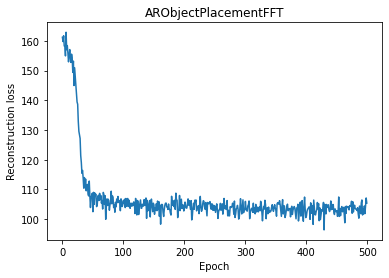

In [40]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
for f in files:
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    settings=set_settings(opts,modload=False,save=True)
    helpers.train_network(settings)
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)

# Get embeddings

In [41]:
dat=list()
dfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    
    #run
    encs,encz,d=helpers.enc_network(settings)

    # make deterministic embeddings
    subj=pd.read_csv('python_names_Notmissing/'+re.sub('.csv','',f)+'_subj.csv')['x']
    sc=pd.DataFrame({'scode_'+re.sub('.csv','',f):pd.Series(np.array([i for i in encs])),'SUBJID':subj})  
    zc=pd.DataFrame({'zcode_'+re.sub('.csv','',f):pd.Series(np.array([i[0] for i in encz])),'SUBJID':subj})
    ##change by Meemansa for ALTOIDA version 4(duplicate IDs for some patients)
    enc=pd.merge(sc, zc, on = 'SUBJID')
    #enc=pd.concat([sc, zc], axis=1)
    #enc = enc.iloc[:, :-1]
    ##end of change
    
    
    # save out individual file's metadata
    enc.to_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv',index = False)
    dfs.append(enc)
    dat.append(d)

# join metadata
enc_vars=[pd.read_csv('Saved_Networks/'+re.sub('.csv','',f)+'_meta.csv') for f in files]
meta=helpers.merge_dat(enc_vars)
meta[meta.columns[['Unnamed' not in i for i in meta.columns]]].to_csv('metaenc_nm.csv',index= False)

dat_dic=dict(zip(files,dat))



/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARGlobalTelemetryVariance/ARGlobalTelemetryVariance.ckpt
Model restored: ./Saved_Networks/ARGlobalTelemetryVariance/ARGlobalTelemetryVariance.ckpt
memememe
[[2.07842537e-01 2.39145164e-01 2.28908700e-01 ... 2.27603419e-02
  1.08376828e-02 1.76618867e+00]
 [2.65334794e-01 2.79255603e-01 4.42142598e-01 ... 2.35569256e-02
  7.51360104e-03 2.04816368e+00]
 [5.03607711e-01 3.32619513e-01 5.31465092e-01 ... 4.72677676e-02
  3.28042085e-02 1.49623972e+00]
 ...
 [4.70607714e-01 5.69749609e-01 1.42416390e+00 ... 3.48304457e-03
  3.98612681e-03 9.84541518e-01]
 [2.97433387e-01 3.09838353e-01 7.08923057e-01 ... 2.55578797e-03
  5.46411674e-03 2.51981876e+00]
 [5.50199319e-01 5.71819841e-01 1.50248974e+00 ... 5.68789583e-03
  4.00319010e-03 2.76234508e+00]]
memememe
[[2.07842537e-01 2.3914516

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARIntroReadTimes/ARIntroReadTimes.ckpt
Model restored: ./Saved_Networks/ARIntroReadTimes/ARIntroReadTimes.ckpt
memememe
[[ 8.00200009  6.51999998  1.48200011 10.26300001  1.5059998   8.75700021]
 [31.25499988 14.71499991 16.53999996 53.08800006 28.61100006 24.477     ]
 [ 4.47399998  0.80800009  3.66599989 19.06599998  9.72799993  9.33800006]
 ...
 [ 4.40199995  2.93299985  1.4690001   5.48099995  3.79900002  1.68199992]
 [ 2.37199998  1.04999995  1.32200003  3.21500015  1.07200003  2.14300013]
 [ 2.43199992  1.03299999  1.39899993  8.18700004  6.68099999  1.50600004]]
memememe
[[ 8.00200009  6.51999998  1.48200011 10.26300001  1.5059998   8.75700021]
 [31.25499988 14.71499991 16.53999996 53.08800006 28.61100006 24.477     ]
 [ 4.47399998  0.80800009  3.66599989 19.06599998  9.72799993  9.33800006]
 ...
 [ 4.40199995  2.93299985  1.4690001   5.48099995  3.79900002  1.68199992]
 [ 2.37199998  1.0499

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARObjectPlacement/ARObjectPlacement.ckpt
Model restored: ./Saved_Networks/ARObjectPlacement/ARObjectPlacement.ckpt
memememe
[[ 0.          0.          1.42266667 ...  0.          6.
   6.        ]
 [ 0.          0.          2.101      ...  0.          4.
  16.        ]
 [ 0.          0.          1.095      ...  0.          5.
  10.        ]
 ...
 [ 0.          0.          1.53366667 ...  2.          3.
   6.        ]
 [ 0.          0.          1.27966667 ...  2.         11.
   9.        ]
 [ 0.          0.          1.703      ...  2.          5.
   6.        ]]
memememe
[[ 0.          0.          1.42266667 ...  0.          6.
   6.        ]
 [ 0.          0.          2.101      ...  0.          4.
  16.        ]
 [ 0.          0.          1.095      ...  0.          5.
  10.        ]
 ...
 [ 0.          0.          1.53366667 ...  2.          3.
   6

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARObjectPlacementFFT/ARObjectPlacementFFT.ckpt
Model restored: ./Saved_Networks/ARObjectPlacementFFT/ARObjectPlacementFFT.ckpt
memememe
[[2.02984746 3.99792664 7.05464273 ... 0.22052556 0.19224858 0.17446011]
 [2.3143757  2.41794776 8.29414544 ... 0.09480041 0.0746972  0.06023484]
 [2.39222458 1.57148317 5.32942535 ... 0.06944855 0.05157049 0.03765497]
 ...
 [0.97057149 1.6898623  3.04564592 ... 0.07917557 0.0568363  0.03870125]
 [1.68609664 1.50068394 2.18658884 ... 0.05451909 0.06778854 0.04059085]
 [1.26455002 3.15431252 5.61471634 ... 0.03830415 0.02485478 0.03663164]]
memememe
[[2.02984746 3.99792664 7.05464273 ... 0.22052556 0.19224858 0.17446011]
 [2.3143757  2.41794776 8.29414544 ... 0.09480041 0.0746972  0.06023484]
 [2.39222458 1.57148317 5.32942535 ... 0.06944855 0.05157049 0.03765497]
 ...
 [0.97057149 1.6898623  3.04564592 ... 0.07917557 

In [42]:
meta = pd.read_csv("metaenc_nm.csv", sep = ',')
meta

,scode_ARGlobalTelemetryVariance,SUBJID,zcode_ARGlobalTelemetryVariance,scode_ARIntroReadTimes,zcode_ARIntroReadTimes,scode_ARObjectPlacement,zcode_ARObjectPlacement,scode_ARObjectPlacementFFT,zcode_ARObjectPlacementFFT
0,0,009-20_001_1,-1.055429,0,-0.807634,0,0.022475,0,1.264795
1,0,009-20_002_1,-0.146182,1,2.449254,0,-0.437236,0,-0.126046
2,0,009-20_003_1,0.327793,1,0.493582,0,-1.876029,0,0.167775
3,0,009-20_004_1,-1.031359,1,1.924763,0,-0.850849,0,0.316008
4,0,009-20_005_1,-1.566372,1,0.905288,0,-0.452257,0,1.223408
...,...,...,...,...,...,...,...,...,...
173,0,005_012_2,0.580616,1,0.652739,0,-1.189616,0,-0.543294
174,0,005_012_3,0.464994,0,-3.059822,0,-2.697182,0,-0.143235
175,0,005_015_1,1.327726,0,-1.808163,0,-2.387399,0,2.793536
176,0,005_015_2,0.096925,0,-2.655607,0,-0.694188,0,5.344139


Text(0.5, 0.98, 'HI-VAE embeddings (deterministic)')

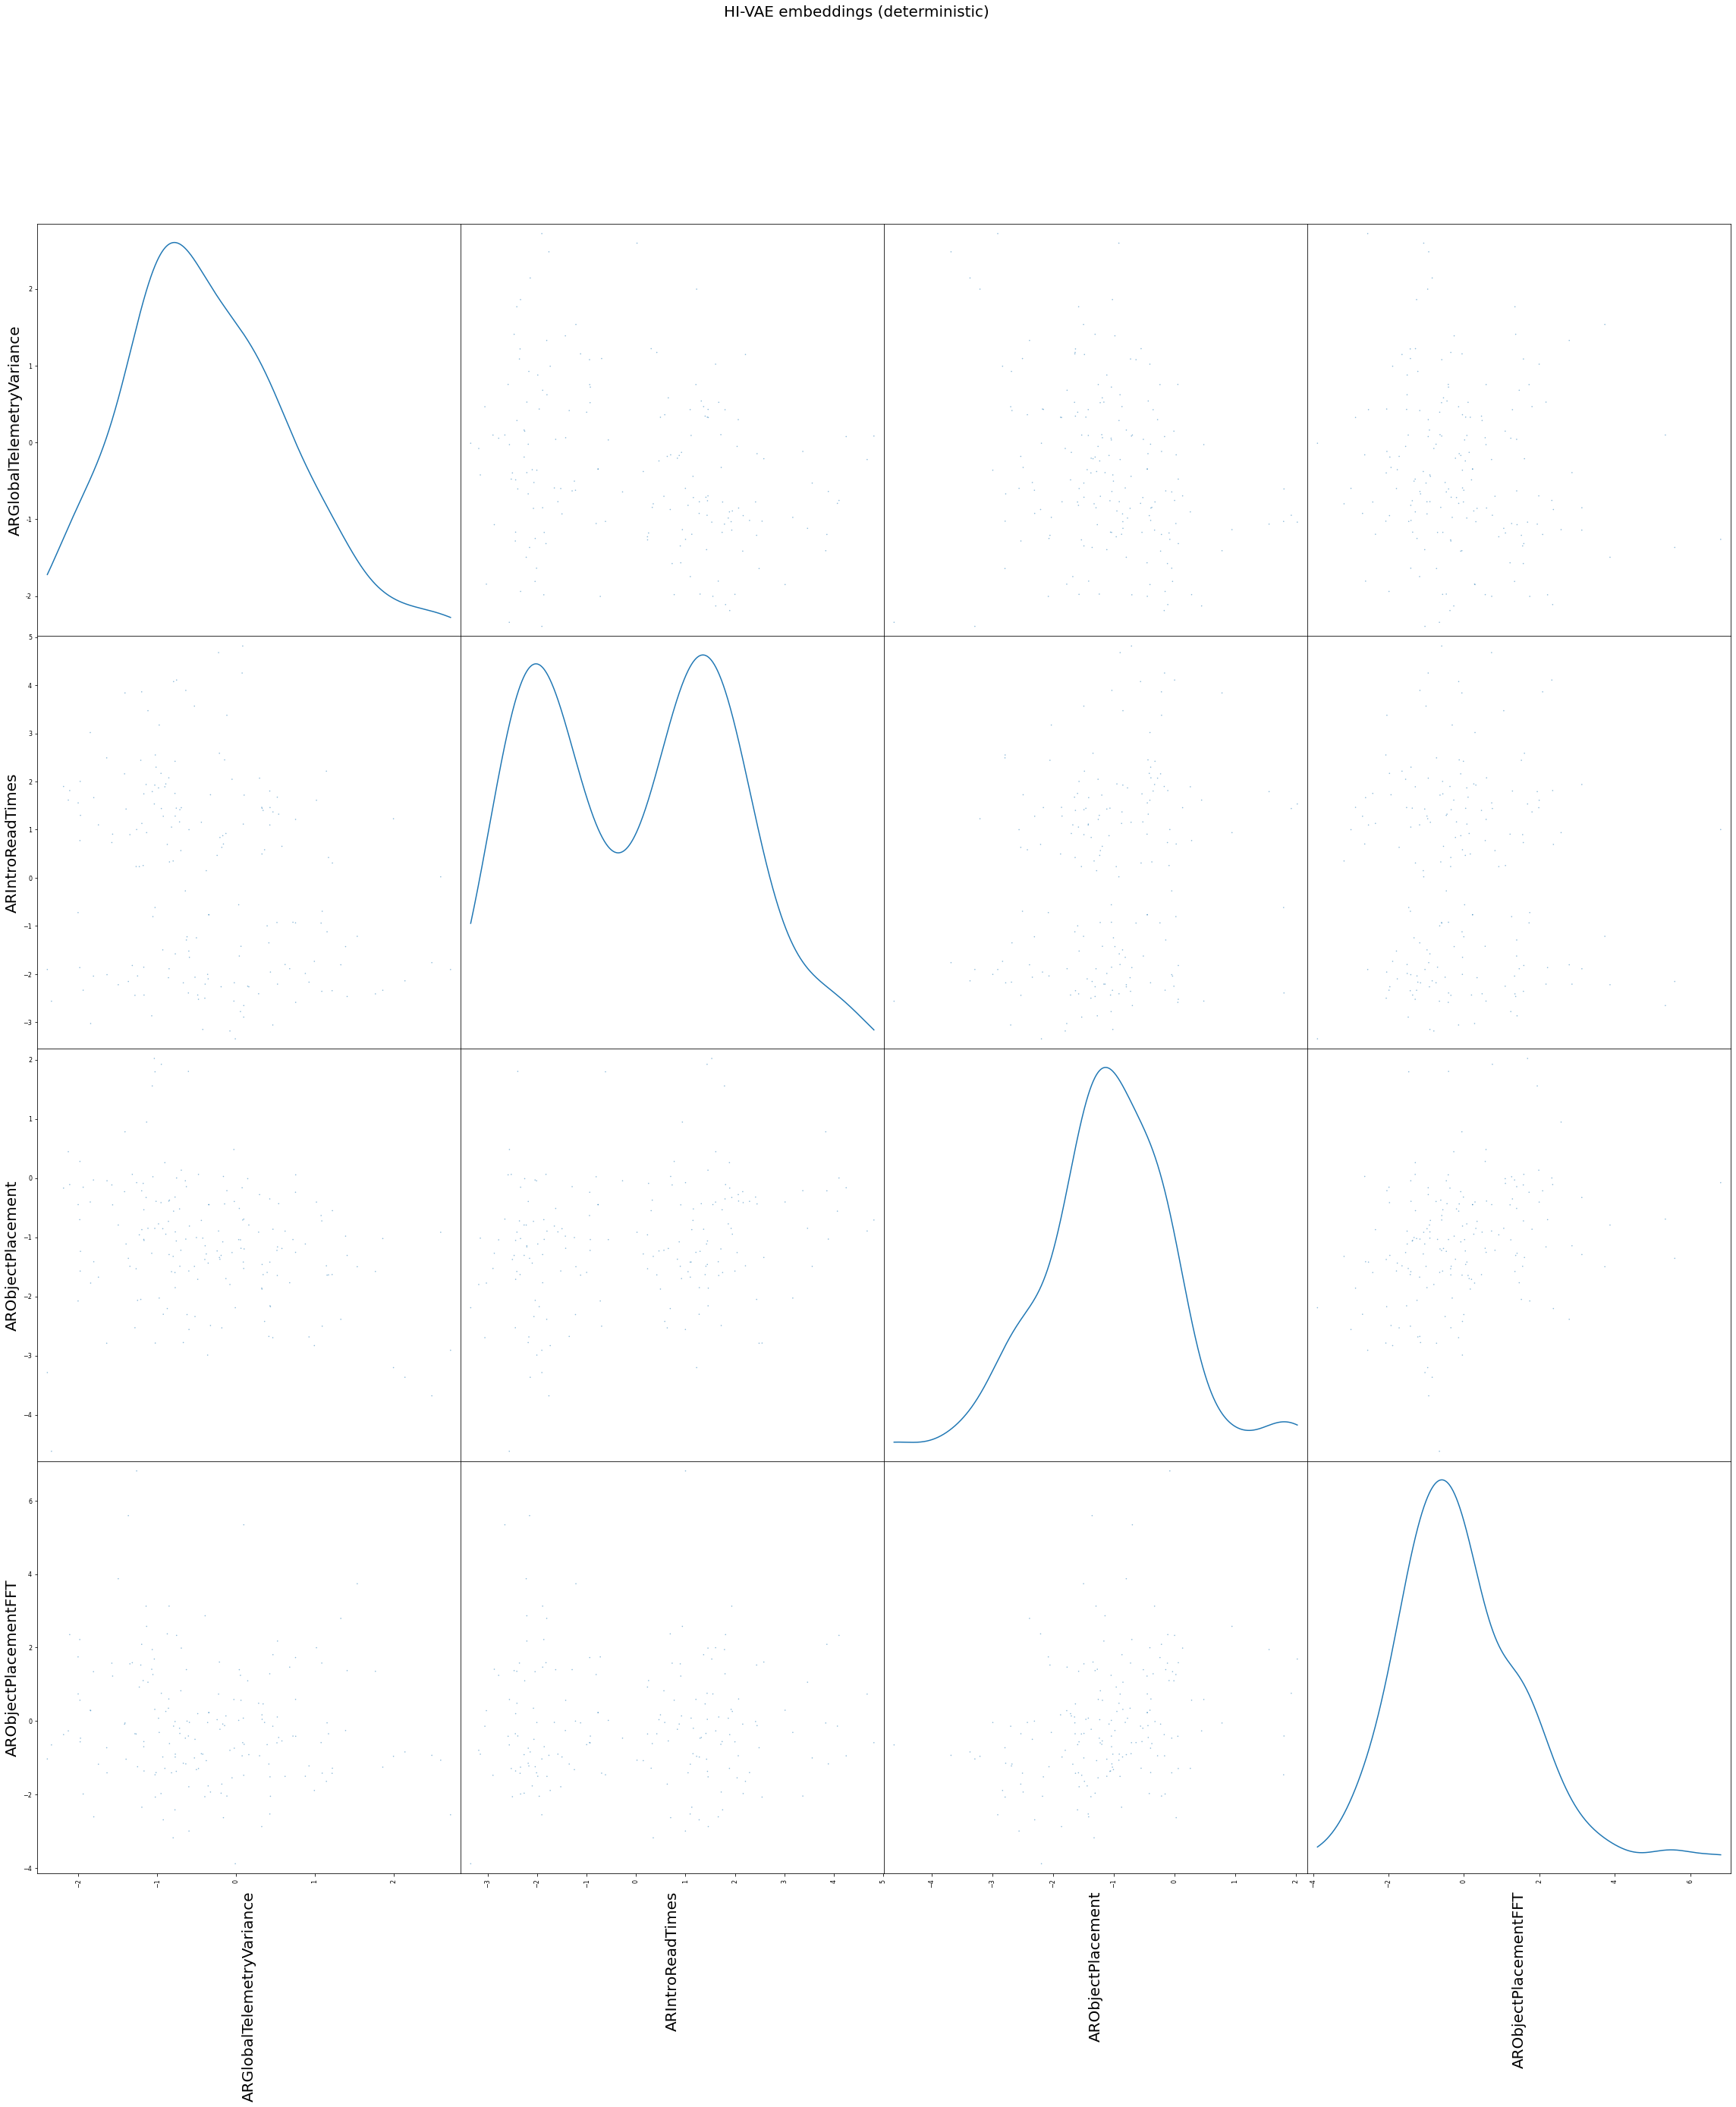

In [43]:
fig = scatter_matrix(
    meta[meta.columns.drop(list(meta.filter(regex='SUBJID|scode_')))],
    figsize  = [40, 40],
    marker   = ".",
    s        = 10,
    diagonal = "kde"
)
for ax in fig.ravel():
    ax.set_xlabel(re.sub('_VIS|zcode_','',ax.get_xlabel()), fontsize = 20, rotation = 90)
    ax.set_ylabel(re.sub('_VIS|zcode_','',ax.get_ylabel()), fontsize = 20, rotation = 90)
    
plt.suptitle('HI-VAE embeddings (deterministic)',fontsize=20)

# RP decoding (Reconstruction)

In [44]:
meta = pd.read_csv('metaenc_nm.csv')
sample_size = 178
recon=list()
recdfs=list()
for f in files:
    # replace placeholders in template
    opts=dict(best_hyper[best_hyper['files'].copy()==f])
    opts['nbatch'].iloc[0]=sample_size
    settings=set_settings(opts,nepochs=1,modload=True,save=False)
    
    #run
    zcodes=meta['zcode_'+re.sub('.csv','',f)]
    scodes=meta['scode_'+re.sub('.csv','',f)]
    rec=helpers.dec_network(settings,zcodes,scodes)
    recon.append(rec)
    
    subj=pd.read_csv('python_names_Notmissing/'+re.sub('.csv','',f)+'_subj.csv')['x']
    names=pd.read_csv('python_names_Notmissing/'+re.sub('.csv','',f)+'_cols.csv')['x']
    recd=pd.DataFrame(rec)
    recd.columns=names
    recd['SUBJID']=subj
    recdfs.append(recd)
    
recon_dic=dict(zip(files,recon))

data_recon=helpers.merge_dat(recdfs)
data_recon.to_csv('reconRP_nm.csv',index=False)

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Importing model: model_HIVAE_inputDropout
[*] Defining placeholders
[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARGlobalTelemetryVariance/ARGlobalTelemetryVariance.ckpt
Model restored: ./Saved_Networks/ARGlobalTelemetryVariance/ARGlobalTelemetryVariance.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
memememe
[[2.07842537e-01 2.39145164e-01 2.28908700e-01 ... 2.27603419e-02
  1.08376828e-02 1.76618867e+00]
 [2.65334794e-01 2.79255603e-01 4.42142598e-01 ... 2.35569256e-02
  7.51360104e-03 2.04816368e+00]
 [5.03607711e-01 3.32619513e-01 5.31465092e-01 ... 4.72677676e-02
  3.28042085e-02 1.49623972e+00]
 ...
 [4.70607714e-01 5.69749609e-01 1.42416390e+00 ... 3.48304457e-03
  3.98612681e-03 9.84541518e-01]
 [2.97433387e-01 3.09838353e-01 7.08923057e-

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARIntroReadTimes/ARIntroReadTimes.ckpt
Model restored: ./Saved_Networks/ARIntroReadTimes/ARIntroReadTimes.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
memememe
[[ 8.00200009  6.51999998  1.48200011 10.26300001  1.5059998   8.75700021]
 [31.25499988 14.71499991 16.53999996 53.08800006 28.61100006 24.477     ]
 [ 4.47399998  0.80800009  3.66599989 19.06599998  9.72799993  9.33800006]
 ...
 [ 4.40199995  2.93299985  1.4690001   5.48099995  3.79900002  1.68199992]
 [ 2.37199998  1.04999995  1.32200003  3.21500015  1.07200003  2.14300013]
 [ 2.43199992  1.03299999  1.39899993  8.18700004  6.68099999  1.50600004]]
memememe
[[ 8.00200009  6.51999998  1.48200011 10.26300001  1.5059998   8.75700021]
 [31.25499988 14.71499991 16.53999996 53.08800006 28.61100006 24.477     ]
 [ 4.47399

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARObjectPlacement/ARObjectPlacement.ckpt
Model restored: ./Saved_Networks/ARObjectPlacement/ARObjectPlacement.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
memememe
[[ 0.          0.          1.42266667 ...  0.          6.
   6.        ]
 [ 0.          0.          2.101      ...  0.          4.
  16.        ]
 [ 0.          0.          1.095      ...  0.          5.
  10.        ]
 ...
 [ 0.          0.          1.53366667 ...  2.          3.
   6.        ]
 [ 0.          0.          1.27966667 ...  2.         11.
   9.        ]
 [ 0.          0.          1.703      ...  2.          5.
   6.        ]]
memememe
[[ 0.          0.          1.42266667 ...  0.          6.
   6.        ]
 [ 0.          0.      

/Users/meemansasood/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[*] Defining Encoder...
[*] Defining Decoder...
[*] Defining Cost function...
INFO:tensorflow:Restoring parameters from ./Saved_Networks/ARObjectPlacementFFT/ARObjectPlacementFFT.ckpt
Model restored: ./Saved_Networks/ARObjectPlacementFFT/ARObjectPlacementFFT.ckpt
::::::DECODING:::::::::
miss_list
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
memememe
[[2.02984746 3.99792664 7.05464273 ... 0.22052556 0.19224858 0.17446011]
 [2.3143757  2.41794776 8.29414544 ... 0.09480041 0.0746972  0.06023484]
 [2.39222458 1.57148317 5.32942535 ... 0.06944855 0.05157049 0.03765497]
 ...
 [0.97057149 1.6898623  3.04564592 ... 0.07917557 0.0568363  0.03870125]
 [1.68609664 1.50068394 2.18658884 ... 0.05451909 0.06778854 0.04059085]
 [1.26455002 3.15431252 5.61471634 ... 0.03830415 0.02485478 0.03663164]]
memememe
[[2.02984746 3.99792664 7.05464273 ... 0.22052556 0.19224858 0.17446011]
 [2.3143757